In [1]:
from __future__                           import print_function
%matplotlib inline

import re
import os
import sys
import h5py

import matplotlib.pyplot                  as plt
import numpy                              as np
import random                             as rd
import tables                             as tb
import tensorflow                         as tf

from glob                                 import glob
from matplotlib.patches                   import Ellipse


# Keras imports
import keras.backend.tensorflow_backend   as   K

from keras                                import regularizers
from keras                                import callbacks

from keras.models                         import Model, load_model

from keras.layers                         import Input, Dense, MaxPooling3D, AveragePooling3D
from keras.layers                         import Conv3D, Conv2D, AveragePooling2D, Activation, Dropout, ZeroPadding3D
from keras.layers                         import Add
from keras.layers                         import Flatten, BatchNormalization

from keras.layers.normalization           import BatchNormalization
from keras.layers.convolutional           import Convolution2D, MaxPooling2D
from keras.layers.core                    import Flatten

from keras.optimizers                     import SGD, Adam, Nadam, Adadelta 

from keras.regularizers                   import l2, l1
from keras.initializers                   import RandomNormal

from keras.utils.layer_utils              import print_summary


#os.environ['CUDA_DEVICE_ORDER'] = 'PCI_BUS_ID'
#os.environ['CUDA_VISIBLE_DEVICES'] = '3'

Using TensorFlow backend.


### Create a combined file from several .npz files

In [ ]:
npz_dir = "/home/amenkara/petalo_files_26_nov/"

# input/output files

files = glob(npz_dir + '*.npz')

files = sorted(files)
print(files)

out_file = "combined_file_26nov.npz"

X_    = []
Compt_= []
Var_  = []
Mean_ = [] 
Ev_   = []


for f in files:

    fn = np.load(f)
    
    if(len(X_) == 0):
        X_     = fn['X_train']
        Compt_ =  fn['Compt_train']
        Var_   =  fn['Varpos_train']
        Mean_  =  fn['Meanpos_train']
        Ev_    =  fn['Ev_train']
    else:
        X_     = np.concatenate((X_,     fn['X_train'])      )
        Compt_ = np.concatenate((Compt_, fn['Compt_train'])  ) 
        Var_   = np.concatenate((Var_,   fn['Varpos_train']) )
        Mean_  = np.concatenate((Mean_,  fn['Meanpos_train']))
        Ev_    = np.concatenate((Ev_,    fn['Ev_train'])     )
    
print("Saving combined file")

np.savez(out_file,
        X_=X_, Compt_= Compt_, Var_=Var_, Mean_=Mean_, Ev_=Ev_)

### Load the data from the dataset

In [2]:
out_file = "training_set_test.npz"

In [3]:
data = np.load(out_file)
X_, Compt_, Ev_ = data['images'],data['labels'], data['event_number']

In [4]:
len(X_)

1095

### Separate train, validation and test set

In [5]:
train_cut = int(0.8*len(X_))
val_cut   = int(0.9*len(X_))

X_train      = X_[:train_cut]
X_val        = X_[train_cut:val_cut] 
X_test       = X_[val_cut:]

Compt_train  =  Compt_[:train_cut]
Compt_val    =  Compt_[train_cut:val_cut]
Compt_test   =  Compt_[val_cut:]

### Define the model

In [119]:
K.clear_session()

In [120]:
def model_CNN(inputs):
    #el 32 implica que hay 32 filtros de 5x5
    cinputs = Conv2D(96, (5, 5), padding='same', strides=(2, 2), activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l1(0.01),  activity_regularizer=regularizers.l1(0.01))(inputs)
    cinputs = AveragePooling2D(pool_size=(2, 2), data_format=None, padding="same", strides=(2, 2))(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=3, momentum=0.99, weights=None, beta_initializer='zero', gamma_initializer='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
    cinputs = Conv2D(192, (3, 3), padding='same', strides=(1, 1), activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l1(0.01),  activity_regularizer=regularizers.l1(0.01))(cinputs)
    cinputs = Dropout(.2)(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=3, momentum=0.99, weights=None, beta_initializer='zero', gamma_initializer='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
    cinputs = AveragePooling2D(pool_size=(2, 2), data_format=None, padding="same", strides=(2, 2))(cinputs)
    cinputs = Conv2D(384, (2, 2), padding='same', strides=(1, 1), activation='relu', kernel_initializer='he_normal', kernel_regularizer=regularizers.l1(0.01), activity_regularizer=regularizers.l1(0.01))(cinputs)
    cinputs = Dropout(.2)(cinputs)
    cinputs = BatchNormalization(epsilon=1e-05, axis=3, momentum=0.99, weights=None, beta_initializer='zero', gamma_initializer='one', gamma_regularizer=None, beta_regularizer=None)(cinputs)
    cinputs = AveragePooling2D(pool_size=(2, 2), data_format=None, padding="same", strides=(2, 2))(cinputs)
    
    f1 = Flatten()(cinputs)
    f1 = Dense(units=64, activation='relu', kernel_initializer='he_normal')(f1)
    #f1 = Dropout(.2)(f1)

    inc_output = Dense(units=1, activation='sigmoid', kernel_initializer='lecun_normal')(f1)
    
    model = Model(inputs, inc_output)
    
    model.compile(loss='binary_crossentropy',
                      optimizer=Nadam(lr=0.0001, beta_1=0.9, beta_2=0.999,
                                      epsilon=1e-08, schedule_decay=0.001), metrics=['accuracy'])
    
    return model

In [121]:
dim     = 30

input_  = Input((dim,dim,1))
model   = model_CNN(input_)

In [122]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 30, 30, 1)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 15, 15, 96)        2496      
_________________________________________________________________
average_pooling2d_1 (Average (None, 8, 8, 96)          0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 8, 8, 96)          384       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 8, 8, 192)         166080    
_________________________________________________________________
dropout_1 (Dropout)          (None, 8, 8, 192)         0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 8, 8, 192)         768       
__________

In [123]:
tboard = callbacks.TensorBoard(log_dir='./logs/test_2', histogram_freq=0, write_graph=True, write_images=False)

### Training

In [124]:
model.fit(X_train, Compt_train, batch_size=18, epochs=10, shuffle=False, callbacks=[tboard],verbose=1, validation_data=(X_val, Compt_val))

Train on 876 samples, validate on 109 samples
Epoch 1/10
876/876 [==============================] - 8s 10ms/step - loss: 709.1304 - acc: 0.5537 - val_loss: 548.3447 - val_acc: 0.4771
Epoch 2/10
876/876 [==============================] - 6s 7ms/step - loss: 513.4497 - acc: 0.6301 - val_loss: 437.1606 - val_acc: 0.6881
Epoch 3/10
876/876 [==============================] - 6s 7ms/step - loss: 430.0793 - acc: 0.6621 - val_loss: 374.7164 - val_acc: 0.6697
Epoch 4/10
876/876 [==============================] - 6s 6ms/step - loss: 369.1792 - acc: 0.6918 - val_loss: 325.6683 - val_acc: 0.6789
Epoch 5/10
876/876 [==============================] - 6s 6ms/step - loss: 318.0704 - acc: 0.6929 - val_loss: 285.8881 - val_acc: 0.6697
Epoch 6/10
876/876 [==============================] - 5s 6ms/step - loss: 276.0823 - acc: 0.6895 - val_loss: 254.8207 - val_acc: 0.6697
Epoch 7/10
876/876 [==============================] - 6s 6ms/step - loss: 245.4819 - acc: 0.6861 - val_loss: 231.5110 - val_acc: 0.6789
E

In [125]:
prediction = model.predict(X_test, batch_size=18, verbose=0)

In [126]:
print(prediction)

[[0.64670146]
 [0.67738295]
 [0.6780841 ]
 [0.6869407 ]
 [0.67786455]
 [0.677837  ]
 [0.7486085 ]
 [0.6778427 ]
 [0.6767174 ]
 [0.61790603]
 [0.67825085]
 [0.6778206 ]
 [0.67780066]
 [0.67780066]
 [0.6835331 ]
 [0.67612964]
 [0.6447569 ]
 [0.67751473]
 [0.6778408 ]
 [0.67788243]
 [0.6778227 ]
 [0.6786429 ]
 [0.56059176]
 [0.6702236 ]
 [0.68456787]
 [0.6782481 ]
 [0.6777771 ]
 [0.47137603]
 [0.67674243]
 [0.6777595 ]
 [0.67780066]
 [0.67755866]
 [0.67780066]
 [0.6777272 ]
 [0.67780066]
 [0.6769617 ]
 [0.709999  ]
 [0.646541  ]
 [0.67759967]
 [0.71087873]
 [0.67780066]
 [0.6777986 ]
 [0.673027  ]
 [0.48225918]
 [0.67797095]
 [0.67780066]
 [0.6801827 ]
 [0.67777264]
 [0.6799147 ]
 [0.6794535 ]
 [0.6960231 ]
 [0.67780066]
 [0.67050195]
 [0.6796907 ]
 [0.70458573]
 [0.67780066]
 [0.6777984 ]
 [0.6777956 ]
 [0.6637436 ]
 [0.67762786]
 [0.6957956 ]
 [0.6776073 ]
 [0.67780066]
 [0.6781926 ]
 [0.64862925]
 [0.67394435]
 [0.6800188 ]
 [0.67323494]
 [0.6745418 ]
 [0.67780066]
 [0.67552894]
 [0.67

In [127]:
def plot_result(cut):
    elements = []
    for element in prediction:
        if element > cut:
            elements.append(0)
        else:
            elements.append(1)
        
    aciertos = 0
    total = len(elements)
    for i in range(total):
        if elements[i]== Compt_test[i]:
            aciertos += 1
        
    print(aciertos)    
    return aciertos/total

In [131]:
matrix = []
for i in range(500, 1000):
    matrix.append([i/1000., plot_result(i/1000.)])
        

33
33
33
33
33
33
33
33
33
33
33
33
33
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
34
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
35
36
36
36
36
36
36
37
37
37
37
37
37
37
38
38
38
38
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
37
36
36
36
36
36
36
36
37
37
37
37
37
37
38
38
38
38
38
38
38
39
39
39
40
40
40
40
41
41
43
43
42
42
42
42
42
42
42
42
42
42
42
42
43
43
43
44
44
44
44
44
44
44
46
46
47
46
49
49
49
71
72
73
76
77
77
78
79
79
78
78
78
78
78
78
78
78
78
79
80
80
80
80
80
80
80
80
81
81
81
81
81
80
79
80
80
80
80
80
80
80
80
80
80
80
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
79
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
80
8

In [129]:
np.transpose(matrix)[1]

array([0.3       , 0.3       , 0.30909091, 0.30909091, 0.30909091,
       0.30909091, 0.30909091, 0.31818182, 0.32727273, 0.34545455,
       0.33636364, 0.33636364, 0.32727273, 0.33636364, 0.35454545,
       0.38181818, 0.38181818, 0.4       , 0.66363636, 0.70909091,
       0.72727273, 0.72727273, 0.72727273, 0.71818182, 0.71818182,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273,
       0.72727273, 0.72727273, 0.72727273, 0.72727273, 0.72727273])

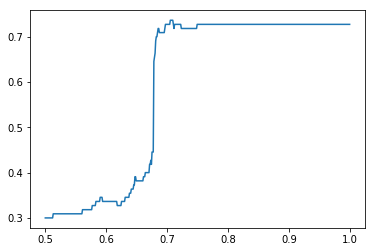

In [133]:
plt.plot(np.transpose(matrix)[0][:], np.transpose(matrix)[1][:])

In [ ]:
score = []
